In [19]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings(action='ignore')

# Text processing and vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Pipeline and transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [20]:
varzos_clean =pd.read_csv(r'/Users/eeshanimaheshgundi/Downloads/varzos_ml.csv')

In [21]:
custom_stopwords = nltk.corpus.stopwords.words('english')

stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 'pfizer', 
                 'biontech', 'nan', 'none', 'mg', 'medical', 'history', 'allergy', 
                 'year', 'old','uk','nkda','nka','known','reported','listed']

In [22]:
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,\
                                 token_pattern=r"(?u)\b\w+\b",\
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2),max_features=5000))])

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define preprocessing (only existing columns)
numeric_features = ['AGE_YRS', 'HOSPDAYS']   
categorical_features = ['SEX']
text_feature = 'SYMPTOM_TEXT'

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='drop'
)



In [24]:
tfidfprocess = ColumnTransformer(transformers=[('text1', textTransformer_0, 'SYMPTOM_TEXT'),
                                              ('text2', textTransformer_0, 'OTHER_MEDS'),
                                              ('text3', textTransformer_0, 'CUR_ILL'),
                                              ('text4', textTransformer_0, 'HISTORY'),
                                              ('text5', textTransformer_0, 'ALLERGIES')
],remainder='passthrough')

In [25]:
vaccine_data = pd.get_dummies(varzos_clean.VAX_MANU)
varzos_clean = pd.merge(varzos_clean, vaccine_data, left_index=True, right_index=True)
varzos_clean.rename(columns = {'GLAXOSMITHKLINE BIOLOGICALS':'GLAXOSMITHKLINE','MERCK & CO. INC.': 'MERCK'}, inplace = True)


In [26]:
varzos_clean.OTHER_MEDS = varzos_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
varzos_clean.CUR_ILL = varzos_clean.CUR_ILL.replace(np.nan,'',regex=True)
varzos_clean.HISTORY = varzos_clean.HISTORY.replace(np.nan,'',regex=True)
varzos_clean.ALLERGIES = varzos_clean.ALLERGIES.replace(np.nan,'',regex=True)
     


In [27]:
from sklearn.model_selection import train_test_split

y=varzos_clean.SERIOUS
X=varzos_clean.drop(['SERIOUS','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 51,947
Test examples: 22,264


In [28]:
pipeline_logistic = Pipeline([
    ('tfidf', tfidfprocess),  # Use the TF-IDF transformer
    ('classifier', LogisticRegression(max_iter=1000, random_state=200))
])

In [29]:
# Add onset lag feature if not already present
if 'NUMDAYS' not in varzos_clean.columns:
    if 'VAX_DATE' in varzos_clean.columns and 'ONSET_DATE' in varzos_clean.columns:
        varzos_clean['VAX_DATE'] = pd.to_datetime(varzos_clean['VAX_DATE'], errors='coerce')
        varzos_clean['ONSET_DATE'] = pd.to_datetime(varzos_clean['ONSET_DATE'], errors='coerce')
        varzos_clean['NUMDAYS'] = (varzos_clean['ONSET_DATE'] - varzos_clean['VAX_DATE']).dt.days
    else:
        print("⚠️ VAX_DATE or ONSET_DATE not found. Creating NUMDAYS=0.")
        varzos_clean['NUMDAYS'] = 0



⚠️ VAX_DATE or ONSET_DATE not found. Creating NUMDAYS=0.


In [30]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                                                               'nan',
                                                                                               'none',
                                                                                               'mg',
                                                                                               'medical',
                                                                                               'history',
                                                                                               'allergy',
                                                                                               'year',
                                                                                               'old',
                                                                                               'uk',
                                                                                               'nkda',
                                                                                               'nka',
                                                                                               'known',
                                                                                               'reported',
                                                                                               '...
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                      

\n=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     19722
           1       0.62      0.87      0.73      2542

    accuracy                           0.92     22264
   macro avg       0.80      0.90      0.84     22264
weighted avg       0.94      0.92      0.93     22264

Accuracy: 0.9246 | ROC-AUC: 0.9643 | PR-AUC: 0.8615


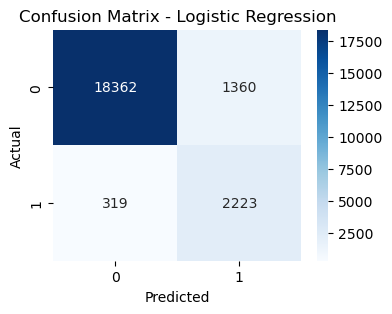

\n=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     19722
           1       0.76      0.75      0.76      2542

    accuracy                           0.94     22264
   macro avg       0.86      0.86      0.86     22264
weighted avg       0.94      0.94      0.94     22264

Accuracy: 0.9447 | ROC-AUC: 0.9583 | PR-AUC: 0.8542


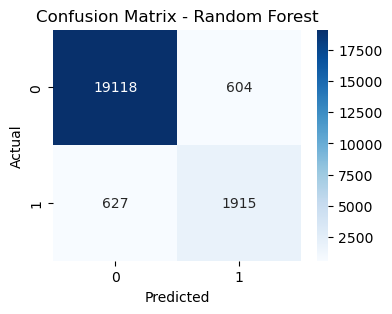

\n=== XGBoost ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     19722
           1       0.92      0.63      0.74      2542

    accuracy                           0.95     22264
   macro avg       0.94      0.81      0.86     22264
weighted avg       0.95      0.95      0.95     22264

Accuracy: 0.9508 | ROC-AUC: 0.9587 | PR-AUC: 0.8655


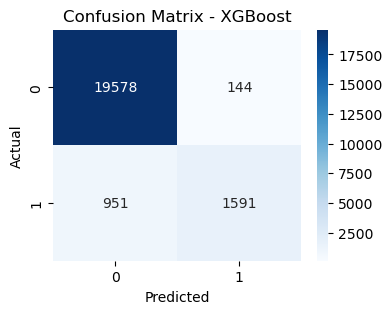

\nModel Comparison Summary:


,Model,Accuracy,ROC-AUC,PR-AUC
0,Logistic Regression,0.924587,0.964295,0.861492
1,Random Forest,0.944709,0.958341,0.854240
2,XGBoost,0.950817,0.958727,0.865487


In [31]:
# ======================================================
# 🔁 Train and compare multiple classifiers
# ======================================================

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"\\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append((name, acc, roc_auc, pr_auc))

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC-AUC', 'PR-AUC'])
print("\\nModel Comparison Summary:")
display(results_df)


In [32]:
# Predict on the test data
y_pred_log = pipeline_logistic.predict(X_test)

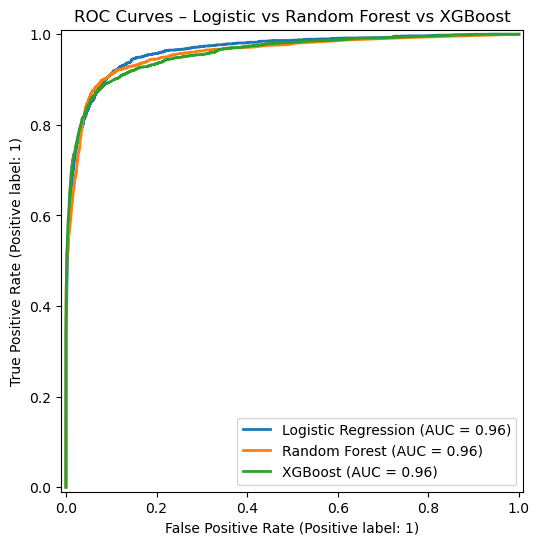

In [33]:
# ======================================================
# 📈 Plot ROC Curves for all models together
# ======================================================

plt.figure(figsize=(8,6))

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(
        y_test, y_pred_proba, name=name, ax=plt.gca(), lw=2
    )

plt.title("ROC Curves – Logistic vs Random Forest vs XGBoost")
plt.legend(loc="lower right")
plt.show()


In [34]:
import time

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Track training time
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    # Track prediction time
    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"Training time: {training_time:.2f} sec | Prediction time: {prediction_time:.2f} sec")

    results.append((name, acc, precision, recall, f1, roc_auc, pr_auc, mcc, training_time, prediction_time))

results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
    'ROC-AUC', 'PR-AUC', 'MCC', 'Train Time (s)', 'Predict Time (s)'
])

display(results_df.sort_values(by='ROC-AUC', ascending=False))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     19722
           1       0.62      0.87      0.73      2542

    accuracy                           0.92     22264
   macro avg       0.80      0.90      0.84     22264
weighted avg       0.94      0.92      0.93     22264

Accuracy: 0.9246 | ROC-AUC: 0.9643 | PR-AUC: 0.8615
Training time: 1.46 sec | Prediction time: 0.46 sec

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     19722
           1       0.76      0.75      0.76      2542

    accuracy                           0.94     22264
   macro avg       0.86      0.86      0.86     22264
weighted avg       0.94      0.94      0.94     22264

Accuracy: 0.9447 | ROC-AUC: 0.9583 | PR-AUC: 0.8542
Training time: 81.32 sec | Prediction time: 1.18 sec

=== XGBoost ===
              precision    recall  f1-score   support

           0 

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Train Time (s),Predict Time (s)
0,Logistic Regression,0.924587,0.620430,0.874508,0.725878,0.964295,0.861492,0.697159,1.461982,0.457689
2,XGBoost,0.950817,0.917003,0.625885,0.743979,0.958727,0.865487,0.733885,9.954012,0.533071
1,Random Forest,0.944709,0.760222,0.753344,0.756767,0.958341,0.854240,0.725587,81.317922,1.176380


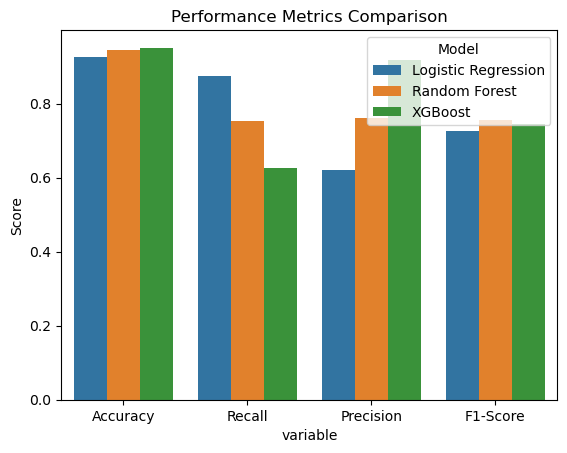

In [35]:
sns.barplot(data=results_df.melt(id_vars='Model',
            value_vars=['Accuracy','Recall','Precision','F1-Score']),
            x='variable', y='value', hue='Model')
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.show()


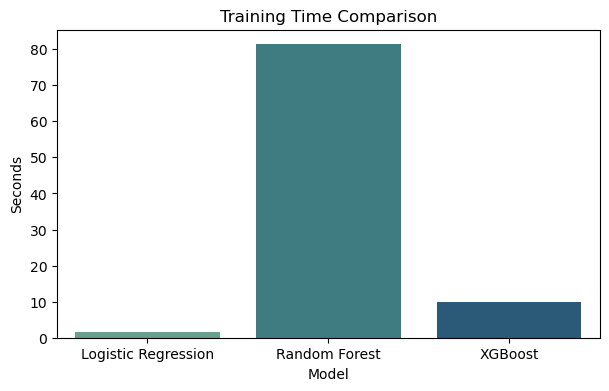

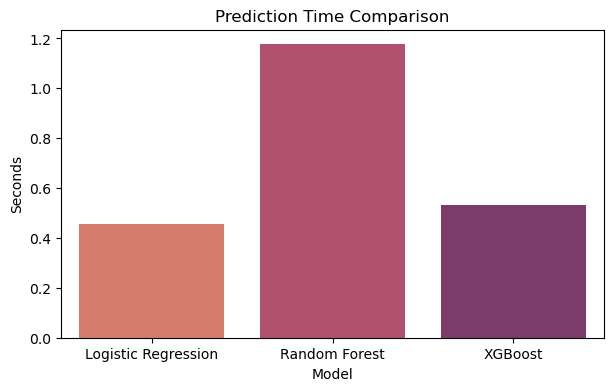

In [36]:
# 🔹 Plot Training Time Comparison
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x='Model', y='Train Time (s)', palette='crest')
plt.title('Training Time Comparison')
plt.ylabel('Seconds')
plt.show()

# 🔹 Plot Prediction Time Comparison
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x='Model', y='Predict Time (s)', palette='flare')
plt.title('Prediction Time Comparison')
plt.ylabel('Seconds')
plt.show()

In [37]:
fastest_train = results_df.loc[results_df['Train Time (s)'].idxmin(), 'Model']
fastest_predict = results_df.loc[results_df['Predict Time (s)'].idxmin(), 'Model']

print(f"⚡ Fastest to train: {fastest_train}")
print(f"⚡ Fastest to predict: {fastest_predict}")

⚡ Fastest to train: Logistic Regression
⚡ Fastest to predict: Logistic Regression
